In [1]:
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = np.loadtxt("Datasets\X.dat").T
Y = np.loadtxt("Datasets\Y.dat")

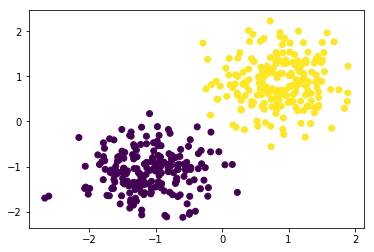

In [3]:
plt.scatter(X[:, 0], X[:, 1], c = Y)

In [4]:
num_observations = len(Y)
num_features = X.shape[-1]

In [5]:
weight = cvxpy.Variable(num_features, 1)
objective = cvxpy.Minimize(cvxpy.sum_squares(weight))
constraints = [Y.reshape(num_observations,1) * X * weight >= np.ones(num_observations)]
problem = cvxpy.Problem(objective, constraints)
result = problem.solve()

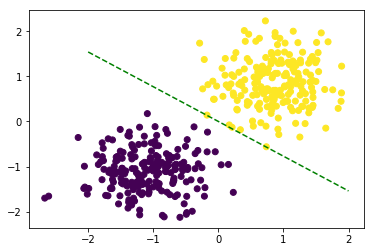

In [6]:
plt.scatter(X[:, 0], X[:, 1], c = Y)
coordinate_1 = np.linspace(-2,2,100)
coordinate_2 = -coordinate_1 * weight.value[0,0] / weight.value[1,0]
plt.plot(coordinate_1, coordinate_2, "g--")

In [7]:
X_intercept = np.concatenate((X,np.ones(num_observations).reshape(num_observations, 1)), axis = 1)

In [8]:
weight = cvxpy.Variable(num_features + 1, 1)
objective = cvxpy.Minimize(cvxpy.sum_squares(weight))
constraints = [Y.reshape(num_observations,1) * X_intercept * weight >= np.ones(num_observations)]
problem = cvxpy.Problem(objective, constraints)
result = problem.solve()

In [9]:
weight.value

matrix([[4.14530517],
        [5.37546613],
        [0.96351349]])

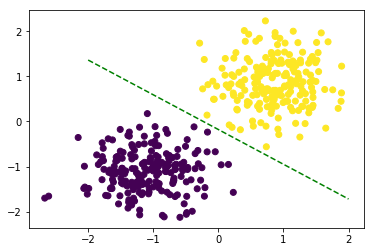

In [10]:
plt.scatter(X[:, 0], X[:, 1], c = Y)
coordinate_1 = np.linspace(-2,2,100)
coordinate_2 = -(coordinate_1  * weight.value[0,0] + weight.value[2,0]) / weight.value[1,0]
plt.plot(coordinate_1, coordinate_2, "g--")

# Kernelization

In [11]:
class RBF_Kernel():
    
    '''
    Radial Basis Function kernel is used to compute
    the Gaussian transform of the inner product,
    namely, k(x, y) = exp(-d||x - y||^2)
    where d is the precision parameter
    for Gaussian distribution.
    
    '''
    
    def __init__(self, d = 1):
        self._dimension = None
        self._precision = d

    def compute_kernel(self, X_train, x_new):
        if X_train.ndim == 1 and x_new.ndim == 1:
            return np.exp(-self._precision * np.linalg.norm(X_train - x_new) ** 2)
        elif (X_train.ndim == 1 and x_new.ndim > 1) or (X_train.ndim > 1 and x_new.ndim == 1):
            return np.exp(-self._precision * np.linalg.norm(X_train - x_new, axis = 1) ** 2)
        elif X_train.ndim > 1 and x_new.ndim > 1:
            return np.exp(-self._precision * np.linalg.norm(X_train[:, np.newaxis] - x_new[np.newaxis, :], axis = 2) ** 2)     
    def get_dimension(self):
        return np.inf
    
class SVM():
    
    def __init__(self, C, kernel):
        self.C = C
        self.kernel = kernel
        
    def training(self, X, y):
        self.X = X
        self.Y = y
        num_observations, num_features = self.X.shape[0], self.X.shape[-1]
        weight = cvxpy.Variable(num_observations, 1)
        Q = np.dot(np.dot(np.diag(self.Y), self.kernel.compute_kernel(self.X, self.X)), np.diag(self.Y))
        objective = cvxpy.Minimize(0.5 * cvxpy.quad_form(weight, Q) - cvxpy.sum_entries(weight))
        constraints = [cvxpy.sum_entries(self.Y *  weight) == 0, 
               np.zeros(num_observations)<= weight, weight<=self.C * np.ones(num_observations)]
        problem = cvxpy.Problem(objective, constraints)
        result = problem.solve()
        self.alpha = np.array(weight.value)
        
    def predicting(self, X):
        return np.sign(np.dot(self.alpha.T * self.Y.T, self.kernel.compute_kernel(self.X, X)))

In [12]:
from matplotlib.colors import ListedColormap
def plot_2d_boundary(X, y, predict_function, scale = 1, stride = 0.1, fig_size = (12, 8)):
    # X is a 2d array, covariates
    # Y is an 1d array, labels
    # predict_function maps an observation to a label
    # scale controls the boundary of the plot
    # stride is the step size along the axes
    # fig_size is the size of the figure
    x_min, x_max = X[:, 0].min() - scale, X[:, 0].max() + scale
    y_min, y_max = X[:, 1].min() - scale, X[:, 1].max() + scale
    # Produce the coordinates of the points will be predicted
    xx, yy = np.meshgrid(np.arange(x_min, x_max, stride), np.arange(y_min, y_max, stride))
    Z = predict_function(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.contourf(xx, yy, Z, cmap = plt.cm.binary_r, alpha = 0.2)
    ax.scatter(X[:, 0], X[:, 1], c = y, cmap="gray", edgecolors = 'k')
    ax.set_ylim(yy.min(), yy.max())  

# Example

In [13]:
X = np.random.randn(100,2)
y = np.ones(100)
y[50:90] = -1

In [14]:
svm = SVM(C = 1000, kernel = RBF_Kernel(3))
svm.training(X, y)

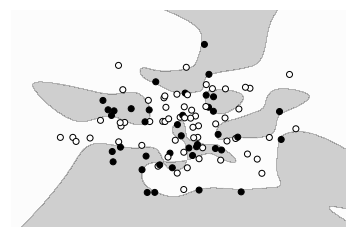

In [15]:
plot_2d_boundary(X, y, svm.predicting, stride = 0.01)